# Minibatch


Why are we re-writing things from scratch?

The idea is that we're trying to learn a library better. If we can't learn what the library does,  we can just re-implement the algorithm ourselves and then we'll be able to understand the library's functions.

In [1]:
#| default_exp training

In [111]:
#| export
from __future__ import annotations
import torch
from torch import nn
import math

In [3]:
# Get the MNIST dataset
import gzip, pickle
import urllib.request
from pathlib import Path
import matplotlib.pyplot as plt

MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"
data_path = Path("../data")
data_path.mkdir(parents=True, exist_ok=True)
data_gz = data_path/"mnist.pkl.gz"

# Get the data
if not data_gz.exists():
    urllib.request.urlretrieve(MNIST_URL, data_path/"mnist.pkl.gz")
    
# Destructuring
with gzip.open(data_gz, mode='rb') as unzip_data:
    obj = pickle.load(unzip_data, encoding="latin-1")
    ((x_train, y_train), (x_valid, y_valid), _) = obj

# To tensors
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

In [4]:
n, m = x_train.shape
c = int(y_train.max()+1)
nh = 50
n, m, c, nh

(50000, 784, 10, 50)

In [5]:
# Our model architecture from 03_backpropagation.ipynb

class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [
            nn.Linear(n_in, nh), # [784,50]
            nn.ReLU(),
            nn.Linear(nh, n_out) # [50,10]
        ]
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [6]:
model = Model(m, nh, c)
preds = model(x_train)
preds.shape # We are now going to use 10 categories for output

torch.Size([50000, 10])

## Implement `Cross Entropy Loss` function

In the last notebook, we used the MSE (L2-norm) to calculate the error. That function was not ideal for predicting multicategory classifications, like MNIST. Following, we are going to reconstruct the `cross entropy loss` function from scratch. 

The targets will be `on-hot-encoded` vectors with the index of a 1 representing the actual number.

**`Cross Entropy Loss` typically serves multi-class and multi-label classifications.**

`Cross Entropy Loss = log(SoftMax(i))`

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss:

In [7]:
# softmax: x.exp()/(x.exp().sum(dim=-1, keepdim=True))

def softmax(x):
    """ Softmax """
    return (x.exp()/(x.exp().sum(dim=-1, keepdim=True))).log()

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax:

In [8]:
#log(softmax(x)):
def log_softmax(x):
    return x - x.exp().sum(-1,keepdim=True).log()

In [9]:
log_softmax_preds = log_softmax(preds)
log_softmax_preds

tensor([[-2.3140, -2.4207, -2.4118,  ..., -2.4077, -2.2544, -2.1577],
        [-2.3702, -2.2981, -2.4286,  ..., -2.4238, -2.2824, -2.0687],
        [-2.2985, -2.4252, -2.3934,  ..., -2.4363, -2.2550, -2.1677],
        ...,
        [-2.2846, -2.3885, -2.3132,  ..., -2.4210, -2.3262, -2.1728],
        [-2.3040, -2.4356, -2.4731,  ..., -2.4082, -2.2953, -2.1849],
        [-2.3516, -2.3857, -2.3335,  ..., -2.4001, -2.2399, -2.1858]],
       grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

In `PyTorch` this is known as : negative log likelihood loss == `nll`

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

In [10]:
# First 3 numbers
y_train[0:3]

tensor([5, 0, 4])

In [11]:
log_softmax_preds.shape

torch.Size([50000, 10])

In [12]:
# The prababilities of the categories from above are
log_softmax_preds[0, 5], log_softmax_preds[1, 0], log_softmax_preds[2, 4]

(tensor(-2.2620, grad_fn=<SelectBackward0>),
 tensor(-2.3702, grad_fn=<SelectBackward0>),
 tensor(-2.4032, grad_fn=<SelectBackward0>))

In [13]:
log_softmax_preds[0, y_train[0]], log_softmax_preds[1, y_train[1]], log_softmax_preds[2, y_train[2]]

(tensor(-2.2620, grad_fn=<SelectBackward0>),
 tensor(-2.3702, grad_fn=<SelectBackward0>),
 tensor(-2.4032, grad_fn=<SelectBackward0>))

In [14]:
log_softmax_preds[[0,1,2], y_train[:3]]

tensor([-2.2620, -2.3702, -2.4032], grad_fn=<IndexBackward0>)

So, we have the `log(softmax(p))`. Now we need to implement the Cross entropy loss from above as the sum of those.

In [15]:
def nll(inp, target):
    """ Cross Entropy Loss """
    return -inp[range(target.shape[0]), target].mean()

In [16]:
loss = nll(log_softmax_preds, y_train)
loss

tensor(2.3058, grad_fn=<NegBackward0>)

### Going to PyTorch

`PyTorch` already has a function for `Cross Entropy Loss`, so we can use that.

In [17]:
import torch.nn.functional as F

# nll = negative log likelihood loss
F.nll_loss(F.log_softmax(preds, dim=1), y_train)

tensor(2.3058, grad_fn=<NllLossBackward0>)

The above combination of the 2 functions can be combined into 1:

In [18]:
F.cross_entropy(preds, y_train)

tensor(2.3058, grad_fn=<NllLossBackward0>)

## Basic training loop

1) get the predictions from the model
2) calculate the loss from the predictions (based on y_train)
3) calculate the gradients of the loss with respect to every parameter of the model
4) adjust the parameters according to their gradients and learning rate

In [19]:
loss_func = F.cross_entropy

In [20]:
bs = 64
xb = x_train[:bs] # minibatch from x
preds = model(xb)
preds[0], preds.shape

(tensor([-0.0060, -0.1127, -0.1038, -0.0005, -0.0785,  0.0460,  0.1590, -0.0996,
          0.0537,  0.1504], grad_fn=<SelectBackward0>),
 torch.Size([64, 10]))

In [21]:
yb = y_train[:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [22]:
loss_func(preds, yb)

tensor(2.2974, grad_fn=<NllLossBackward0>)

We need to grab the highest probabilities of the predicted nubmers.

In [23]:
# These are the indexes of the highest probabilities
# preds.argmax(dim=1)
preds.argmax(dim=1)

tensor([6, 9, 6, 9, 9, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 9, 6, 9, 6, 6, 8, 9, 6, 9,
        6, 6, 6, 9, 6, 6, 6, 9, 6, 9, 9, 6, 6, 9, 6, 6, 6, 9, 9, 9, 6, 9, 6, 6,
        6, 9, 9, 9, 9, 6, 9, 6, 9, 9, 9, 9, 6, 6, 6, 9])

And we define the accuracy:

In [24]:
#|export
def accuracy(preds, targs) -> float:
    """ The average accuracy of the correctly predicted numbers """
    return (preds.argmax(dim=1)==targs).float().mean()

In [25]:
accuracy(preds, yb)

tensor(0.1875)

In [26]:
#|export
def report(epoch:int, preds:torch.tensor, targs:torch.tensor, loss:float):
    """ Print a report """
    print(f"epoch:{epoch}\n#-------------------------#")
    print(f"accuracy:{accuracy(preds, targs).item():.3f} \t loss:{loss.item():.5f}")
    print("#=========================#")

In [27]:
xb, yb = x_train[:bs], y_train[:64]
preds = model(xb)
report(1, preds, yb, loss_func(preds, yb))

epoch:1
#-------------------------#
accuracy:0.188 	 loss:2.29740
#=========================#


Let's setup the basic training loop:

In [28]:
# Recreate the model before running the training
model = Model(m, nh, c)

In [29]:
batch_size = 64
epochs = 3
lr = 0.5

for epoch in range(epochs):

    for i in range(0, x_train.shape[0], batch_size):
        
        # Create xb, yb batch - this operation is way slower than slice
        if i+batch_size > x_train.shape[0]:
            xb = x_train[i:]
            yb = y_train[i:]
        else:
            xb = x_train[i:i+batch_size] # x batch
            yb = y_train[i:i+batch_size] # y batch
            
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        loss.backward()
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, "weight"):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    print(f"epoch:{epoch} \t accuracy:{accuracy(preds, yb).item():.6f} \t loss:{loss.item():.6f}")

epoch:0 	 accuracy:0.937500 	 loss:0.303032
epoch:1 	 accuracy:1.000000 	 loss:0.085718
epoch:2 	 accuracy:1.000000 	 loss:0.075807


### Using `slice`

The `slice()` function returns a `slice object` that is used to slice any sequence (string, tuple, list, range, or bytes). So, we can use it to slice the training tensors.

In [30]:
model = Model(m, nh, c)

In [31]:
bs = 64
epochs = 3
lr = 0.5
n_inp = x_train.shape[0]

for epoch in range(epochs):
    for i in range(0, n_inp, 64):
        s = slice(i, min(n_inp, i + bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        loss.backward()
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, "weight"):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(epoch, preds, yb, loss)

epoch:0
#-------------------------#
accuracy:0.938 	 loss:0.23894
#=========================#
epoch:1
#-------------------------#
accuracy:1.000 	 loss:0.13703
#=========================#
epoch:2
#-------------------------#
accuracy:0.938 	 loss:0.11017
#=========================#


### PyTorch parameters

We are going to reduce the code size for the parameter update.

If we create an object which inherits from `nn.Module`, we can assign arbitrary parameters to it and traverse them as well:

In [32]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4)
m1.bar = nn.Linear(4, 1)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
  (bar): Linear(in_features=4, out_features=1, bias=True)
)

In [33]:
# This allows us to access the attributes of m1
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True)),
 ('bar', Linear(in_features=4, out_features=1, bias=True))]

In [34]:
# This prints the weights and bias matrices
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.3266,  0.3039,  0.5283],
         [-0.2270, -0.3690, -0.0490],
         [-0.3799,  0.0288,  0.1058],
         [-0.4960,  0.1610, -0.5476]], requires_grad=True),
 Parameter containing:
 tensor([-0.4991, -0.1271,  0.4899, -0.2653], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0809, -0.4615,  0.4568,  0.2750]], requires_grad=True),
 Parameter containing:
 tensor([-0.4473], requires_grad=True)]

In [35]:
#|export
class MLP(nn.Module):
    """
    Simple Multi Layer Perceptron to illustrate the use of parameter. 
    A MLP has a minimum of 3 layers which makes this one the simplest MLP.
    """
    
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        """ Forward pass """
        return self.l2(self.relu(self.l1(x)))

In [36]:
model = MLP(m, nh, c)
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [37]:
for name, l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


You can access the parameteres (`weights` and `biases`) of each layer of the model:

In [38]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


That means, we can update them in the loop we hade defined before:

In [39]:
model = MLP(m, nh, c)
bs = 64
epochs = 3
lr = 0.5
n_inp = x_train.shape[0]

In [40]:
def fit(model=model, epochs=3):
    """ Basic loop using Torch model parameters to update their gradients. """
    for epoch in range(epochs):
        for i in range(0, n_inp, bs):
            s = slice(i, min(n_inp, i+bs))
            xb = x_train[s]
            yb = y_train[s]
            preds = model(xb) # We are now using the MLP model
            loss = F.cross_entropy(preds, yb)
            loss.backward()
            
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad*lr
                model.zero_grad() # Reset gradients for all model parameters
        report(epoch, preds, yb, loss)

In [41]:
fit()

epoch:0
#-------------------------#
accuracy:0.938 	 loss:0.20501
#=========================#
epoch:1
#-------------------------#
accuracy:1.000 	 loss:0.08821
#=========================#
epoch:2
#-------------------------#
accuracy:1.000 	 loss:0.06692
#=========================#


#### How it works in the background

In the background `PyTorch` uses the `__setattr__()` function which allows you to set arbitrary object properties.

In [42]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self, k, v):
        """ This is how PyTorch.nn.Module stores the children of the model. """
        if not k.startswith("_"):
            self._modules[k] = v
        super().__setattr__(k, v)
    
    def __repr__(self):
        return f"{self._modules}"
    
    def parameters(self):
        """ How to traverse parametes """
        for l in self._modules.values():
            yield from l.parameters()  

In [43]:
mymodel = MyModule(m, nh, c)
mymodel


{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [44]:
for p in mymodel.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering layers in model - from scratch

How do we registers all the layers in our model at once - with `nn.Module`?

In [45]:
# Suppose we store the layers in a variable
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c)]

In [46]:
class Model(nn.Module):
    
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers):
            self.add_module(f"layer_{i}", l) # This adds the modules to the module
            
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [47]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

It's apparent that **we're building a sequential model**.

#### Going to PyTorch - `nn.ModuleList()`

`PyTorch` allows use to add module with the `nn.ModuleList()` function.

https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#modulelist

In [48]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.linears = nn.ModuleList(layers) # Create sequential model

    def forward(self, x):
        for i, l in enumerate(self.linears):
            x = l(x)
        return x
        # return reduce(lambda val,layer: layer(val), self.layers, x)
    # Python reduce: https://realpython.com/python-reduce-function/

In [49]:
seqmodel = SequentialModel(layers)
seqmodel

SequentialModel(
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [50]:
fit(model=seqmodel)

epoch:0
#-------------------------#
accuracy:0.938 	 loss:0.26009
#=========================#
epoch:1
#-------------------------#
accuracy:1.000 	 loss:0.06191
#=========================#
epoch:2
#-------------------------#
accuracy:1.000 	 loss:0.06112
#=========================#


#### Going to PyTorch - `nn.Sequential()`

This is a convenience class which does the same thing as above - it registers our modules for us.

In [51]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [52]:
fit(model=model)

epoch:0
#-------------------------#
accuracy:0.938 	 loss:0.21852
#=========================#
epoch:1
#-------------------------#
accuracy:0.938 	 loss:0.12376
#=========================#
epoch:2
#-------------------------#
accuracy:1.000 	 loss:0.06742
#=========================#


### SGD Optimizer - from scratch

Finding the gradients of the layers and updating the parameters is a common step. An optimizer is a function which does that for us.

```Python
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad*lr
    model.zero_grad() # Reset gradients for all model parameters
```

Let's create our own `optimizer`.

In [53]:
class SGD_Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr
                
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [54]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

In [55]:
# We create opt as an object of the model's parameters
opt = SGD_Optimizer(model.parameters())

In [56]:
# New training loop

for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb = x_train[s]
        yb = y_train[s]
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        loss.backward()
        
        # Out custom SGD optimizer
        opt.step()
        opt.zero_grad()
    report(epoch, preds, yb, loss)

epoch:0
#-------------------------#
accuracy:0.938 	 loss:0.30260
#=========================#
epoch:1
#-------------------------#
accuracy:0.938 	 loss:0.12236
#=========================#
epoch:2
#-------------------------#
accuracy:1.000 	 loss:0.03961
#=========================#


PyTorch provides the same functionality with `optim.SGD` and it also provides the `momentum` parameter (which avoids local minimums during SGD).

#### Going to PyTorch - `optim.SGD`.

In [57]:
from torch import optim

In [58]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
opt = optim.SGD(model.parameters(), lr=0.5)

In [59]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb = x_train[s]
        yb = y_train[s]
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        loss.backward()
        
        # PyTorch's SGD optimizer
        opt.step()
        opt.zero_grad()
    report(epoch, preds, yb, loss)

epoch:0
#-------------------------#
accuracy:0.938 	 loss:0.27220
#=========================#
epoch:1
#-------------------------#
accuracy:0.938 	 loss:0.10800
#=========================#
epoch:2
#-------------------------#
accuracy:1.000 	 loss:0.04318
#=========================#


In [60]:
#|export
def get_lin_model():
    """ Use PyTorch to create the smallest MLP and SGD optimizer. """
    _model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
    _opt = optim.SGD(_model.parameters(), lr=0.5)
    return _model, _opt

## Dataset and DataLoader

We're going to create the `Dataset` and `DataLoader` from scratch to understand how they're implemented in `PyTorch`.

### Dataset

We'll go from:

```python
s = slice(i, min(i+bs, n))
xb = x_train[s]
yb = y_train[s]
```

to

```python
xb,yb = train_ds[s]
```

In [61]:
#|export
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, s):
        """ Slicing function: replaced slice() """
        return self.x[s], self.y[s]

In [62]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(y_valid)

In [63]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [64]:
model, opt = get_lin_model()

In [65]:
# New fit function with Dataset class
def fit(model = model, opt = opt):
    for epoch in range(epochs):
        for i in range(0, n, bs):
            xb, yb = train_ds[i:min(n, i+bs)]
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(epoch, preds, yb, loss)

In [66]:
fit()

epoch:0
#-------------------------#
accuracy:0.938 	 loss:0.20979
#=========================#
epoch:1
#-------------------------#
accuracy:1.000 	 loss:0.07331
#=========================#
epoch:2
#-------------------------#
accuracy:1.000 	 loss:0.03511
#=========================#


### DataLoader

We are going to replace:

```Python
for i in range(0, n, bs):
    xb, yb = train_ds[i:min(n, i+bs)]
```
with:
```Python
for xb, yb in train_dl:
    ...
```

So we need to create an itterator with `__iter__()` and `yield`.

In [67]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:min(len(self.ds), i+self.bs)]

In [68]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [69]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [70]:
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

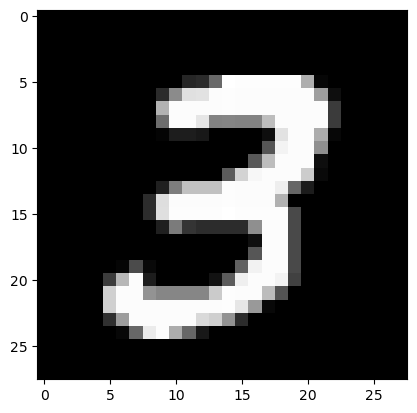

In [71]:
plt.imshow(xb[7].view(28, 28), cmap='gray')

In [72]:
model, opt = get_lin_model()

In [73]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(epoch, preds, yb, loss)

In [74]:
fit()

epoch:0
#-------------------------#
accuracy:0.938 	 loss:0.10618
#=========================#
epoch:1
#-------------------------#
accuracy:0.938 	 loss:0.08907
#=========================#
epoch:2
#-------------------------#
accuracy:1.000 	 loss:0.05057
#=========================#


### Batch randomizer

Now, we have created a way to load datasets into the traininig function. However, the DataLoaderes are sequential - they fetch items in a sequence.

One feature we can add to the `DataLoader` is a shuffler, which fetches random data from the training set.

In [75]:
import random

In [76]:
class Sampler():
    """ Returns an iterator with optionally randomized indexes of the Dataset """
    def __init__(self, ds, shuffle=False):
        self.n = len(ds)
        self.shuffle = shuffle
        
    def __iter__(self):
        """ Returns the indexes which we're going to use to create xb and yb """
        result = list(range(self.n))
        if self.shuffle:
            random.shuffle(result)
        return iter(result)

In [77]:
from itertools import islice

In [78]:
ss = Sampler(train_ds) # If shuffle==False
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [79]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss,5))

[14437, 40643, 43098, 13706, 2976]

Now we can create random indexes for a single batch.

In [80]:
import fastcore.all as fc

In [81]:
class BatchSampler():
    """ Creates batch size Sampler slices. """
    def __init__(self, sampler, bs, drop_last=False):
        fc.store_attr()
    def __iter__(self):
        """ Returns batches of indexes of batch size """
        yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [82]:
batchs = BatchSampler(ss, 5)
list(islice(batchs, 10))
# Now we can generate x amount of randomized indexes of batch size

[[44196, 16341, 11877, 24036, 42466],
 [5432, 11536, 35334, 33224, 26588],
 [34447, 44724, 35057, 36256, 4243],
 [28438, 30429, 2260, 14248, 34686],
 [22293, 49766, 14793, 38714, 29053],
 [36077, 34203, 29360, 32278, 40332],
 [5545, 20410, 49432, 12878, 14760],
 [47476, 16030, 39703, 18614, 22381],
 [25091, 20780, 14741, 19372, 17125],
 [38155, 7282, 40525, 18624, 31133]]

Now we can create batches of random indexes using `Sampler()` and `BatchSampler()`.

However, we need to be returning `torch.Tensors`:

In [83]:
def collate(b):
    """ Splits the x and y into the different tensors """
    # import pdb
    # pdb.set_trace()
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [84]:
a = torch.tensor([1.,3.,6.,10.])
b = torch.tensor([0, 0, 0, 0, ])
torch.stack((a, b))

tensor([[ 1.,  3.,  6., 10.],
        [ 0.,  0.,  0.,  0.]])

In [85]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate):
        fc.store_attr() # Stores everything in __init__() in a self variable
        
    def __iter__(self):
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [86]:
train_ds[:3]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4]))

In [87]:
# Create the batch size indexes
train_sample = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_sample = BatchSampler(Sampler(train_ds, shuffle=False), bs)

In [88]:
list(islice(train_sample, 1)) # 1x64 list of randomized indexes

[[49326,
  25263,
  19786,
  22147,
  36522,
  27160,
  27634,
  42238,
  23976,
  13867,
  41254,
  49616,
  8309,
  17869,
  35529,
  35962,
  17135,
  5378,
  34730,
  18490,
  38723,
  26186,
  43456,
  25266,
  41020,
  4038,
  14793,
  35136,
  31498,
  44424,
  33708,
  7996,
  20744,
  12449,
  13641,
  35204,
  28620,
  11220,
  3630,
  31397,
  15565,
  12078,
  14297,
  12219,
  5153,
  48505,
  49606,
  38689,
  23023,
  3132,
  26306,
  22436,
  35096,
  49997,
  47756,
  47879,
  3749,
  29208,
  11576,
  23252,
  3987,
  22529,
  10571,
  26010]]

In [89]:
# Create the actual iterators over the training and validation Datasets
train_dl = DataLoader(train_ds, batchs=train_sample)
valid_dl = DataLoader(valid_ds, batchs=valid_sample)

In [90]:
xb, yb = next(iter(train_dl)) # That should fetch an xb shuffled

In [91]:
xb.shape, yb.shape # These are randomized training tensors

(torch.Size([64, 784]), torch.Size([64]))

(<matplotlib.image.AxesImage at 0x7f6c6eaf6170>, tensor(3))

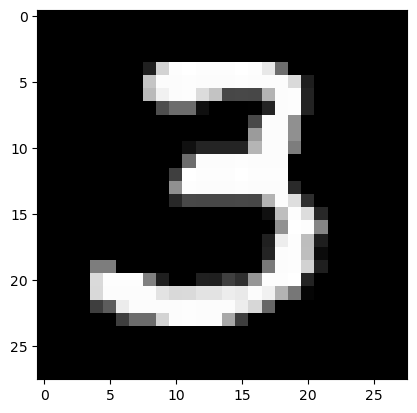

In [92]:
plt.imshow(xb[50].view(28, 28), cmap="gray"), yb[50]

In [93]:
model, opt = get_lin_model()

In [94]:
fit()

epoch:0
#-------------------------#
accuracy:0.750 	 loss:0.55483
#=========================#
epoch:1
#-------------------------#
accuracy:0.938 	 loss:0.17745
#=========================#
epoch:2
#-------------------------#
accuracy:1.000 	 loss:0.00661
#=========================#


The `PyTorch`'s `DataLoaders` work exactly like the implementation above. However, it runs in parallel when the `DataLoader` class.

**I skipped implementing the parallel `DataLoader`.**

### Going to `PyTorch` `DataLoader`

In [95]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [96]:
# Create the batch size indexes
train_sample = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_sample = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [97]:
# Create the DataLoaders using the indexes from above
train_dl = DataLoader(train_ds, batch_sampler=train_sample, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_sample, collate_fn=collate)

In [98]:
model, opt = get_lin_model()
fit()

epoch:0
#-------------------------#
accuracy:1.000 	 loss:0.05168
#=========================#
epoch:1
#-------------------------#
accuracy:0.938 	 loss:0.07762
#=========================#
epoch:2
#-------------------------#
accuracy:1.000 	 loss:0.04102
#=========================#


OR

PyTorch's `DataLoader` can create the (random) batch samples for us - so we can use it directly:

In [99]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [100]:
model, opt = get_lin_model()
fit()

epoch:0
#-------------------------#
accuracy:1.000 	 loss:0.10885
#=========================#
epoch:1
#-------------------------#
accuracy:1.000 	 loss:0.06044
#=========================#
epoch:2
#-------------------------#
accuracy:0.938 	 loss:0.60376
#=========================#


`PyTorch` `DataLoader` can perform the random batch sampling without the having to explicitly create the `RandomSampler`.

In [101]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, drop_last=False, num_workers=2)

In [102]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [103]:
model, opt, get_lin_model()
fit()

epoch:0
#-------------------------#
accuracy:0.969 	 loss:0.07596
#=========================#
epoch:1
#-------------------------#
accuracy:1.000 	 loss:0.03351
#=========================#
epoch:2
#-------------------------#
accuracy:1.000 	 loss:0.01672
#=========================#


## Validation

We've improved out basic training loop. Now, we need to see how it's performing on the validation dataset.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [104]:
T1 = torch.Tensor([1,2,3,4])
T2 = torch.Tensor([5,6, 7,8])
T3 = torch.Tensor()

In [105]:
T3 = torch.cat((T3, T1), dim=0)
T3

tensor([1., 2., 3., 4.])

In [106]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        
        epoch_total_loss = 0
        nof_samples = 0
        cumulative_preds = torch.Tensor()
        cumulative_targs = torch.Tensor()
        
        for xb, yb in train_dl:
            train_preds = model(xb)
            cumulative_preds = torch.cat((cumulative_preds, train_preds))
            cumulative_targs = torch.cat((cumulative_targs, yb))
            train_loss = loss_func(train_preds, yb)
            nof_samples += 1
            epoch_total_loss += train_loss
            train_loss.backward()
            opt.step()
            opt.zero_grad()
        print("Training report")
        report(epoch, cumulative_preds, cumulative_targs, epoch_total_loss/nof_samples)
        
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0.,0.,0
            for xb, yb in valid_dl:
                valid_preds = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(valid_preds, yb).item()*n # Why multiply?
                tot_acc += accuracy(valid_preds, yb)*n
        print("Validation report")
        print(f"valid accuracy: {tot_acc/count:.3}\t valid loss: {tot_loss/count:.3}\n")
    return tot_loss/count, tot_acc/count

In [107]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2, **kwargs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2, **kwargs)
    return(train_dl, valid_dl)

In [108]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_lin_model()

In [109]:
%time loss, acc = fit(5, model, F.cross_entropy, opt, train_dl, valid_dl)

Training report
epoch:0
#-------------------------#
accuracy:0.905 	 loss:0.31069
#=========================#
Validation report
valid accuracy: 0.954	 valid loss: 0.16

Training report
epoch:1
#-------------------------#
accuracy:0.956 	 loss:0.14337
#=========================#
Validation report
valid accuracy: 0.969	 valid loss: 0.115

Training report
epoch:2
#-------------------------#
accuracy:0.967 	 loss:0.10780
#=========================#
Validation report
valid accuracy: 0.968	 valid loss: 0.109

Training report
epoch:3
#-------------------------#
accuracy:0.973 	 loss:0.08703
#=========================#
Validation report
valid accuracy: 0.971	 valid loss: 0.108

Training report
epoch:4
#-------------------------#
accuracy:0.977 	 loss:0.07425
#=========================#
Validation report
valid accuracy: 0.973	 valid loss: 0.103

CPU times: user 18.1 s, sys: 932 ms, total: 19 s
Wall time: 5.03 s


# Export

In [112]:
import nbdev; nbdev.nbdev_export()